# Capstone Project: Police Call Outcome Prediction: Year 2013

This notebook explores and analyzes police call data in the city of San Jose, California, with the goal of predicting whether the outcome will be an arrest, a citation, or neither. The dataset contains various features such as call type, location, and final disposition. Models like Logistic Regression, Random Forest, and others are evaluated for this task.

## Data Loading and Initial Exploration

In this section, we load the police call dataset for analysis and perform some initial data exploration.

In [238]:
# Import necessary libraries for data manipulation, visualization, and machine learning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)  # Ignore future warnings

import importlib

import model_utils
importlib.reload(model_utils)

import collections
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import folium
import numpy as np
from folium.plugins import HeatMap
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
import joblib
import keras_tuner as kt
from tensorflow import keras

import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np
import time

### Data Loading

Here, we load the police call data for the year 2013 from a CSV file.

#### Data Source
* San Jose Police Calls For Service: https://data.sanjoseca.gov/dataset/police-calls-for-service.

In [241]:
years = [2013]
year = "2013"

all_police_df = model_utils.load_data(years)

print(f'length of dataframe = {len(all_police_df)}')

length of dataframe = 314546


### Initial Data Exploration

We explore a sample of the data and generate summary statistics to get an idea of its structure and contents.

In [243]:
all_police_df.sample(5)

,CDTS,EID,START_DATE,CALL_NUMBER,PRIORITY,REPORT_DATE,OFFENSE_DATE,OFFENSE_TIME,CALLTYPE_CODE,CALL_TYPE,FINAL_DISPO_CODE,FINAL_DISPO,ADDRESS,CITY,STATE,LATITUDE,LONGITUDE,neighborhood
220565,20130910165855PD,5005192,5/13/2021 12:00:00 AM,P132530633,3,9/10/2013 12:00:00 AM,9/10/2013 12:00:00 AM,16:31:27,1062,MEET THE CITIZEN,N,No report required; dispatch r,[1200]-[1300] KOCH LN,San Jose,CA,37.282941,-121.882137,Schallenberger
141963,20130616215115PD,4892203,5/13/2021 12:00:00 AM,P131670894,4,6/16/2013 12:00:00 AM,6/16/2013 12:00:00 AM,20:40:01,415M,"DISTURBANCE, MUSIC",N,No report required; dispatch r,[400]-[500] DOYLE RD,San Jose,CA,37.303072,-121.982809,Rogers
42980,20130224172231PS,4749141,5/13/2021 12:00:00 AM,P130550576,3,2/24/2013 12:00:00 AM,2/24/2013 12:00:00 AM,17:17:03,1033A,"ALARM, AUDIBLE",NR,No Response,[300]-[400] S 1ST ST,San Jose,CA,37.336060,-121.890544,Ballbach and SOFA
64958,20130323222645PD,4781618,5/13/2021 12:00:00 AM,P130820942,2,3/23/2013 12:00:00 AM,3/23/2013 12:00:00 AM,21:46:25,415F,"DISTURBANCE, FAMILY",N,No report required; dispatch r,[1100]-[1200] OWSLEY AV,San Jose,CA,37.330365,-121.854497,Owsley
48142,20130303033921PS,4756861,5/13/2021 12:00:00 AM,P130620179,2,3/3/2013 12:00:00 AM,3/3/2013 12:00:00 AM,03:26:03,WELCK,WELFARE CHECK,G,Gone on Arrival/unable to loca,ALMADEN EX & REDMOND AV,San Jose,CA,37.229290,-121.869060,Sunrise Almaden


In [246]:
all_police_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314546 entries, 0 to 314545
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   CDTS              314546 non-null  object 
 1   EID               314546 non-null  int64  
 2   START_DATE        314546 non-null  object 
 3   CALL_NUMBER       314546 non-null  object 
 4   PRIORITY          314546 non-null  int64  
 5   REPORT_DATE       314546 non-null  object 
 6   OFFENSE_DATE      314546 non-null  object 
 7   OFFENSE_TIME      314546 non-null  object 
 8   CALLTYPE_CODE     314546 non-null  object 
 9   CALL_TYPE         314432 non-null  object 
 10  FINAL_DISPO_CODE  314546 non-null  object 
 11  FINAL_DISPO       314546 non-null  object 
 12  ADDRESS           303131 non-null  object 
 13  CITY              314546 non-null  object 
 14  STATE             314546 non-null  object 
 15  LATITUDE          281608 non-null  float64
 16  LONGITUDE         28

In [248]:
all_police_df.describe()

,EID,PRIORITY,LATITUDE,LONGITUDE
count,3.145460e+05,314546.000000,281608.000000,281608.000000
mean,4.914235e+06,3.271296,37.319994,-121.870074
std,1.314685e+05,1.391001,0.043388,0.048296
min,4.684476e+06,1.000000,34.012231,-122.035696
25%,4.800916e+06,2.000000,37.296088,-121.901148
50%,4.913703e+06,3.000000,37.323294,-121.866665
75%,5.027571e+06,4.000000,37.349048,-121.837024
max,5.142920e+06,6.000000,37.534539,-117.901713


In [250]:
all_police_df.describe(include='object')

,CDTS,START_DATE,CALL_NUMBER,REPORT_DATE,OFFENSE_DATE,OFFENSE_TIME,CALLTYPE_CODE,CALL_TYPE,FINAL_DISPO_CODE,FINAL_DISPO,ADDRESS,CITY,STATE,neighborhood
count,314546,314546,314546,314546,314546,314546,314546,314432,314546,314546,303131,314546,314546,280148
unique,311419,1,304239,365,365,80089,219,214,24,18,31962,1,1,295
top,20130417190448PD,5/13/2021 12:00:00 AM,P132070252,7/4/2013 12:00:00 AM,7/4/2013 12:00:00 AM,22:52:20,415,DISTURBANCE,N,No report required; dispatch r,Not a valid geographical locat,San Jose,CA,Spartan Keyes and Wool Creek
freq,3,314546,10,1198,1198,17,31047,31041,129649,129649,2061,314546,314546,7926


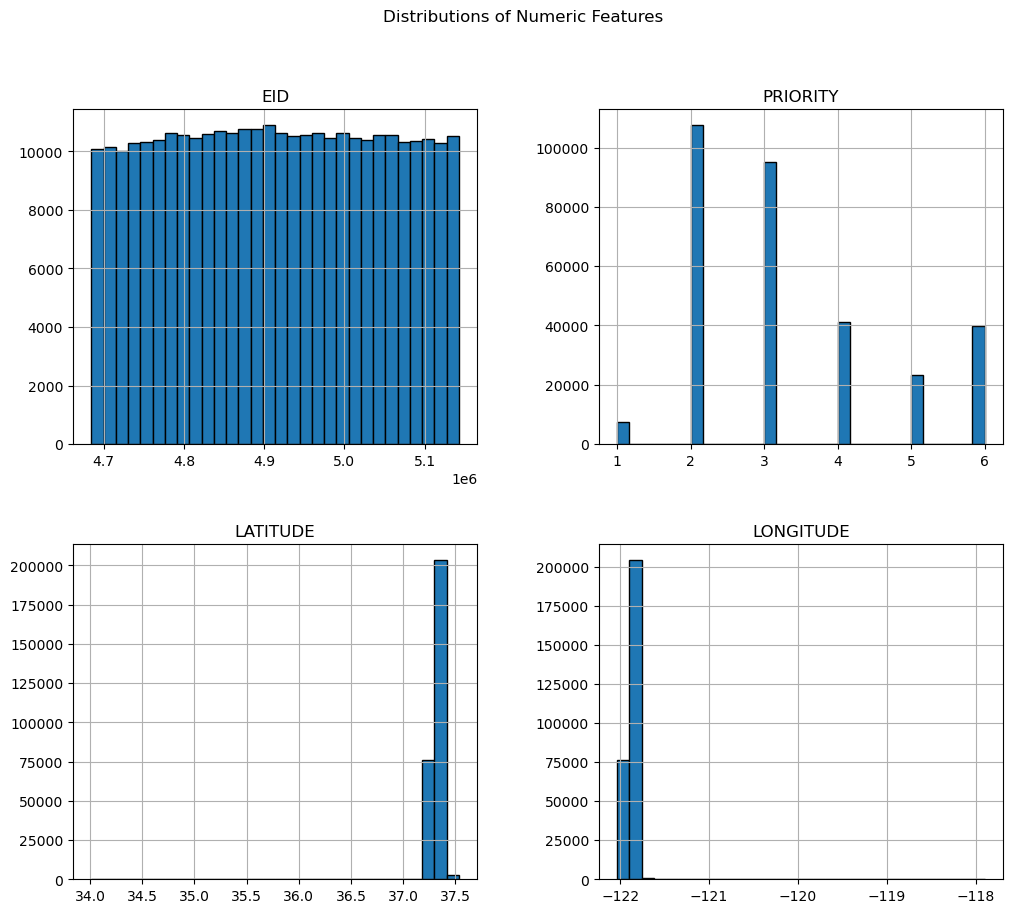

In [252]:
# Plot histograms for numeric columns
all_police_df.hist(figsize=(12, 10), bins=30, edgecolor='black')
plt.suptitle('Distributions of Numeric Features')
plt.show()

In [254]:
missing_data = all_police_df.isnull().sum()
missing_data

CDTS                    0
EID                     0
START_DATE              0
CALL_NUMBER             0
PRIORITY                0
REPORT_DATE             0
OFFENSE_DATE            0
OFFENSE_TIME            0
CALLTYPE_CODE           0
CALL_TYPE             114
FINAL_DISPO_CODE        0
FINAL_DISPO             0
ADDRESS             11415
CITY                    0
STATE                   0
LATITUDE            32938
LONGITUDE           32938
neighborhood        34398
dtype: int64

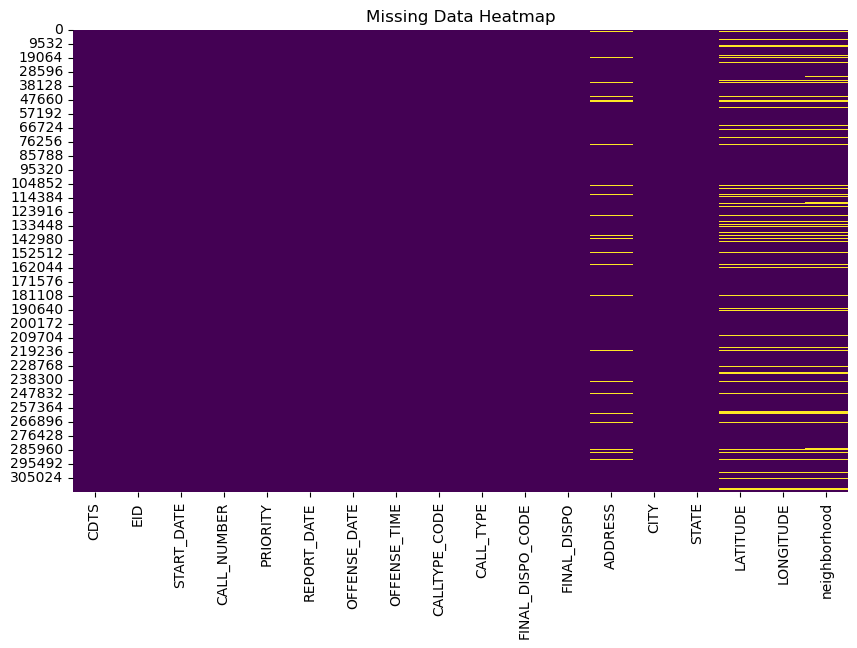

In [256]:
# Visualize missing data
plt.figure(figsize=(10, 6))
sns.heatmap(all_police_df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

In [257]:
for column in all_police_df.select_dtypes(include=['object']).columns:
    unique_values = all_police_df[column].nunique()
    print(f'{column}: {unique_values} unique values')

CDTS: 311419 unique values
START_DATE: 1 unique values
CALL_NUMBER: 304239 unique values
REPORT_DATE: 365 unique values
OFFENSE_DATE: 365 unique values
OFFENSE_TIME: 80089 unique values
CALLTYPE_CODE: 219 unique values
CALL_TYPE: 214 unique values
FINAL_DISPO_CODE: 24 unique values
FINAL_DISPO: 18 unique values
ADDRESS: 31962 unique values
CITY: 1 unique values
STATE: 1 unique values
neighborhood: 295 unique values


In [258]:
all_police_df['neighborhood'].value_counts()

neighborhood
Spartan Keyes and Wool Creek      7926
Little Saigon and Spring Brook    5445
Fruitdale and Sherman Oaks        4925
Five Wounds-San Jose High         4608
Trimble Business Area             4207
                                  ... 
Meadowlands                         55
Linda Vista and Hillcrest           48
Alta Vista                          43
Villages                            40
Santa Teresa Hills                  26
Name: count, Length: 295, dtype: int64

In [259]:
all_police_df['FINAL_DISPO_CODE'].value_counts()

FINAL_DISPO_CODE
N          129649
CAN         48845
R           34790
NR          20726
G           18459
A            8222
ADV          8195
DUPNCAN      6985
GD           6191
E            5917
C            5176
H            4841
T            3616
O            3440
D            2840
B            2645
U            1964
F            1709
P             152
M             149
TOT            21
Z              12
ESNT            1
DUP             1
Name: count, dtype: int64

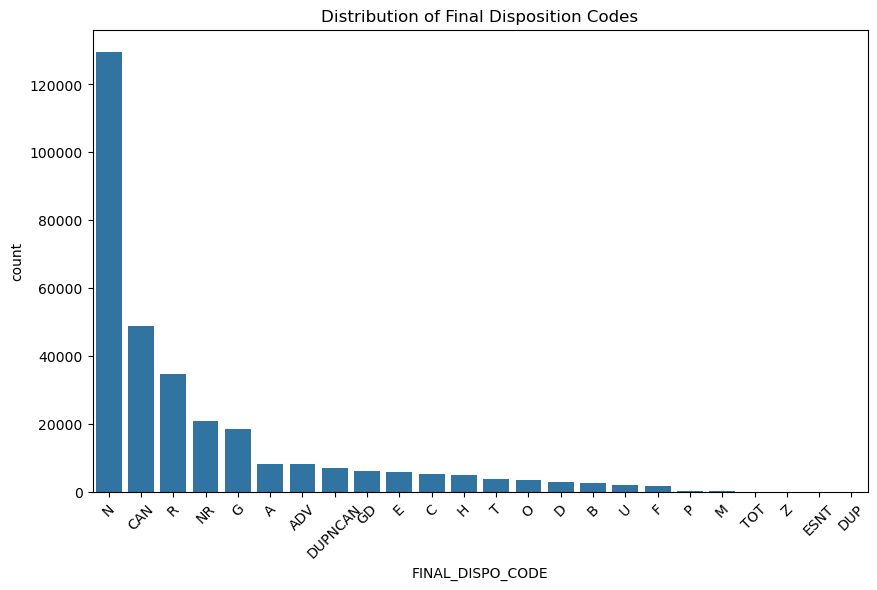

In [260]:
# Bar plot for target variable (FINAL_DISPO_CODE)
plt.figure(figsize=(10, 6))
sns.countplot(data=all_police_df, x='FINAL_DISPO_CODE', order=all_police_df['FINAL_DISPO_CODE'].value_counts().index)
plt.title('Distribution of Final Disposition Codes')
plt.xticks(rotation=45)
plt.show()

In [262]:
all_police_df['FINAL_DISPO'].value_counts()

FINAL_DISPO
No report required; dispatch r    129649
Canceled                           48845
Report taken                       34790
No Disposition                     21406
No Response                        20726
Gone on Arrival/unable to loca     18459
Arrest Made                         8222
Traffic Citation Issued, Non-H      5917
Criminal Citation                   5176
Courtesy Service/Citizen or ag      4841
Turned over To (TOT)                3616
Supplemental report taken           3440
Traffic Citation Issued, Hazar      2840
Arrest by Warrant                   2645
Unfounded event                     1964
Field Interview (F.I.) Complet      1709
Prior case, follow-up activity       152
Stranded motorist assist             149
Name: count, dtype: int64

In [266]:
# Create a mapping between FINAL_DISPO_CODE and FINAL_DISPO
final_dispo_mapping = dict(zip(all_police_df['FINAL_DISPO_CODE'], all_police_df['FINAL_DISPO']))
final_dispo_mapping

{'NR': 'No Response',
 'G': 'Gone on Arrival/unable to loca',
 'CAN': 'Canceled',
 'N': 'No report required; dispatch r',
 'DUPNCAN': 'No Disposition',
 'R': 'Report taken',
 'GD': 'No Disposition',
 'O': 'Supplemental report taken',
 'H': 'Courtesy Service/Citizen or ag',
 'A': 'Arrest Made',
 'T': 'Turned over To (TOT)',
 'U': 'Unfounded event',
 'B': 'Arrest by Warrant',
 'F': 'Field Interview (F.I.) Complet',
 'ADV': 'No Disposition',
 'E': 'Traffic Citation Issued, Non-H',
 'P': 'Prior case, follow-up activity',
 'C': 'Criminal Citation',
 'D': 'Traffic Citation Issued, Hazar',
 'M': 'Stranded motorist assist',
 'ESNT': 'No Disposition',
 'DUP': 'No Disposition',
 'Z': 'No Disposition',
 'TOT': 'No Disposition'}

In [270]:
call_type_code_mapping = dict(zip(all_police_df['CALLTYPE_CODE'], all_police_df['CALL_TYPE']))
call_type_code_mapping

{'415FC': 'DISTURBANCE, FIRECRACKERS',
 '1062': 'MEET THE CITIZEN',
 '1057': 'FIREARMS DISCHARGED',
 '415F': 'DISTURBANCE, FAMILY',
 '647F': 'DRUNK IN PUBLIC',
 '1033A': 'ALARM, AUDIBLE',
 '5150': 'MENTALLY DISTURBED PERSON',
 '1065X': 'MISSING FEMALE',
 '1033S': 'ALARM, SILENT',
 '20002': 'MISDEMEANOR HIT AND RUN',
 '23103': 'RECKLESS DRIVING',
 '415M': 'DISTURBANCE, MUSIC',
 '1033': 'ALARM',
 '911CELL': 'UNK TYPE 911 CALL FROM CELL',
 '23152': 'MISDEMEANOR DUI',
 'SUSCIR': 'SUSPICIOUS CIRCUMSTANCES',
 '415A': 'DISTURBANCE, FIGHT',
 '10851': 'STOLEN VEHICLE',
 '1182': 'VEHICLE ACCIDENT, PROPERTY DAM',
 '415': 'DISTURBANCE',
 '1154': 'SUSPICIOUS VEHICLE',
 '1066': 'SUSPICIOUS PERSON',
 '1067X': 'FEMALE CALLING FOR HELP',
 '1070': 'PROWLER',
 '415UNK': 'DISTURBANCE, UNKNOWN',
 '242': 'BATTERY',
 '22500': 'PARKING VIOLATION',
 '1195': 'VEHICLE STOP',
 '1095': 'PEDESTRIAN STOP',
 '1125': 'TRAFFIC HAZARD',
 '1179': 'VEHICLE ACCIDENT, AMB DISPATCH',
 '537': 'DEFRAUDING AN INKEEPER',
 'WELCK

## Focus on Target Dispositions

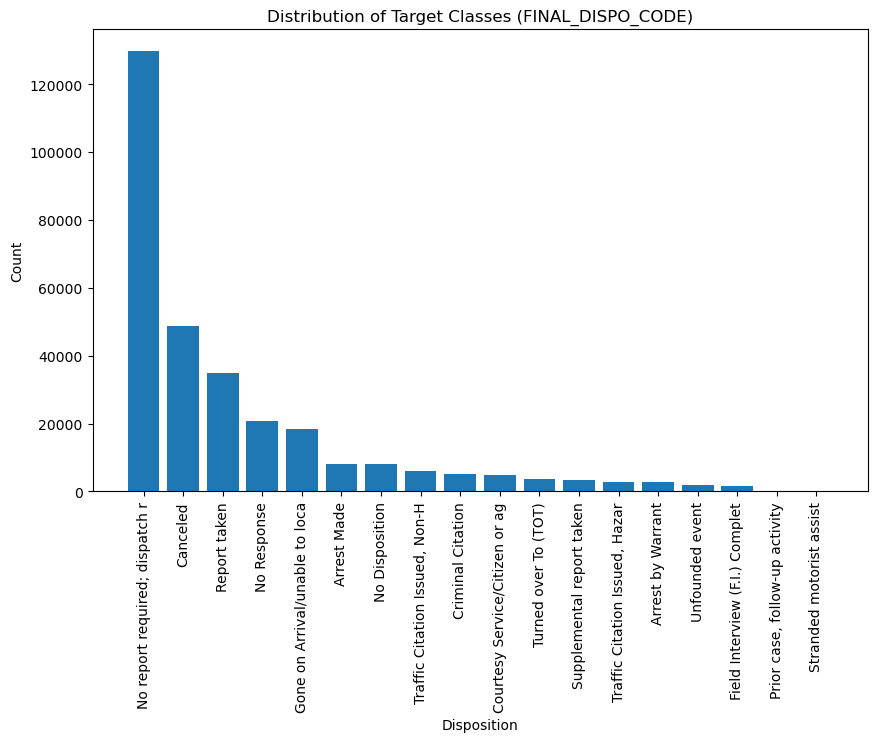

In [273]:
# Get the value counts of the DISPO_SUBSET column
dispo_counts = all_police_df['FINAL_DISPO_CODE'].value_counts()

# Create a list of names using the dispo_mapping
dispo_names = [final_dispo_mapping[code] for code in dispo_counts.index]

# Plot the distribution of target classes with disposition names
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(dispo_names, dispo_counts.values)
plt.title('Distribution of Target Classes (FINAL_DISPO_CODE)')
plt.xlabel('Disposition')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels if needed
plt.show()

In [275]:
model_utils.transform_offense_date(all_police_df)

In [277]:
dispo_mapping = model_utils.calc_dispo_subset(all_police_df)
all_police_df['DISPO_SUBSET'].value_counts()

DISPO_SUBSET
Other    298503
A          8222
C          5176
B          2645
Name: count, dtype: int64

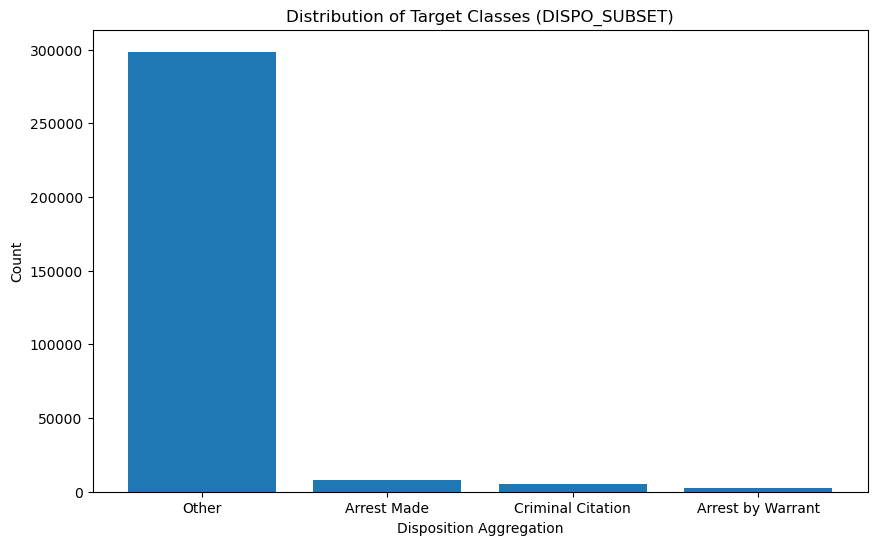

In [279]:
# Get the value counts of the DISPO_SUBSET column
dispo_counts = all_police_df['DISPO_SUBSET'].value_counts()

# Create a list of names using the dispo_mapping
dispo_names = [dispo_mapping[code] for code in dispo_counts.index]

# Plot the distribution of target classes with disposition names
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(dispo_names, dispo_counts.values)
plt.title('Distribution of Target Classes (DISPO_SUBSET)')
plt.xlabel('Disposition Aggregation')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.show()

## Data Cleaning and Feature Engineering

In [282]:
police_calls_encoded = model_utils.clean_and_transform_data(all_police_df)

Police Calls Dataset: 314546 rows before cleaning, 280148 rows after cleaning.


In [284]:
police_calls_encoded.shape

(280148, 15)

In [286]:
police_calls_encoded

,PRIORITY,CALLTYPE_CODE,LATITUDE,LONGITUDE,neighborhood,OFFENSE_HOUR,OFFENSE_DAY_OF_WEEK,OFFENSE_MONTH,OFFENSE_YEAR,AFTER_COVID,DISPO_SUBSET,DISTANCE_FROM_CENTER,LATITUDE^2,LATITUDE LONGITUDE,LONGITUDE^2
0,4,415FC,1.004963,1.403387,Warner Heights,0,1,1,2013,No,Other,0.086896,1.009950,1.410352,1.969495
1,4,1062,0.128902,1.849324,Norwood,0,1,1,2013,No,Other,0.105190,0.016616,0.238381,3.420000
2,2,1057,-0.447139,-2.352147,Starbird,0,1,1,2013,No,Other,0.102209,0.199933,1.051737,5.532595
3,2,1057,0.838283,-0.516958,Japantown and Luna Park,0,1,1,2013,No,Other,0.019477,0.702718,-0.433357,0.267245
4,4,415FC,-2.252439,1.749299,Baldwin,0,1,1,2013,No,Other,0.152051,5.073480,-3.940190,3.060048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314541,4,415FC,-0.068485,-0.248128,Goodyear Mastic,0,1,12,2013,No,Other,0.021668,0.004690,0.016993,0.061567
314542,4,415FC,0.081715,0.577564,Turtle Rock and Meadows,0,1,12,2013,No,Other,0.046405,0.006677,0.047196,0.333580
314543,2,415F,-0.843938,-0.449414,Cherry,0,1,12,2013,No,Other,0.054604,0.712231,0.379277,0.201973
314544,2,1034,-1.455171,0.190525,Branham/Pearl and Erikson,0,1,12,2013,No,Other,0.084598,2.117522,-0.277246,0.036300


## Define X and Y

In [289]:
# load the encoder file
encoder = joblib.load('one_hot_encoder.pkl')

In [291]:
X_train, X_test, y_train, y_test, label_names, class_labels, X_train_resampled, y_train_resampled, _ = \
    model_utils.split_data(police_calls_encoded, dispo_mapping, encoder)

classes = ['A' 'B' 'C' 'Other']
(224118, 14)
(56030, 14)
['Arrest Made', 'Arrest by Warrant', 'Criminal Citation', 'Other']
Counter({3: 212486, 0: 6010, 2: 3687, 1: 1935})
Counter({3: 11632, 0: 6010, 2: 3687, 1: 1935})


In [293]:
X_train.shape

(224118, 529)

In [295]:
X_train

,PRIORITY,LATITUDE,LONGITUDE,DISTANCE_FROM_CENTER,LATITUDE^2,LATITUDE LONGITUDE,LONGITUDE^2,CALLTYPE_CODE_1033,CALLTYPE_CODE_1033A,CALLTYPE_CODE_1033CTX,...,neighborhood_Willow Glen South,neighborhood_Willow Glen West,neighborhood_Willow Vale,neighborhood_Willowmont,neighborhood_Winchester,neighborhood_Winchester Lynnhaven,neighborhood_Windmill Springs,neighborhood_Wooster and East Ct and West Ct,neighborhood_YB Lucretia,AFTER_COVID_Yes
285952,1.977297,-0.270768,-0.088983,-0.803305,-0.681549,0.147063,-0.684058,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
140947,0.535263,-0.006257,-2.075590,0.721782,-0.735385,0.136307,2.281164,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
114245,-0.906771,-0.291493,0.215926,-0.552862,-0.672983,0.064888,-0.657394,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
240966,-0.185754,-0.445520,-1.161675,-0.172880,-0.589529,0.613064,0.241073,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
184650,1.977297,0.292197,-0.200658,-1.486431,-0.672566,0.068875,-0.661746,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231833,-0.185754,1.372661,0.835842,0.291398,0.650519,1.208115,-0.207868,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
109408,1.977297,-0.499688,0.285702,-0.287552,-0.551887,-0.010492,-0.633265,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
110856,-0.185754,-1.312456,1.343750,1.472495,0.531109,-1.541398,0.555419,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49127,-0.906771,-1.642957,0.082637,0.924489,1.249369,-0.003849,-0.684823,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


y_train distribution: Counter({3: 212486, 0: 6010, 2: 3687, 1: 1935})
y_test distribution: Counter({3: 53122, 0: 1502, 2: 922, 1: 484})
y_train_resampled distribution: Counter({3: 212486, 0: 6010, 2: 3687, 1: 1935})


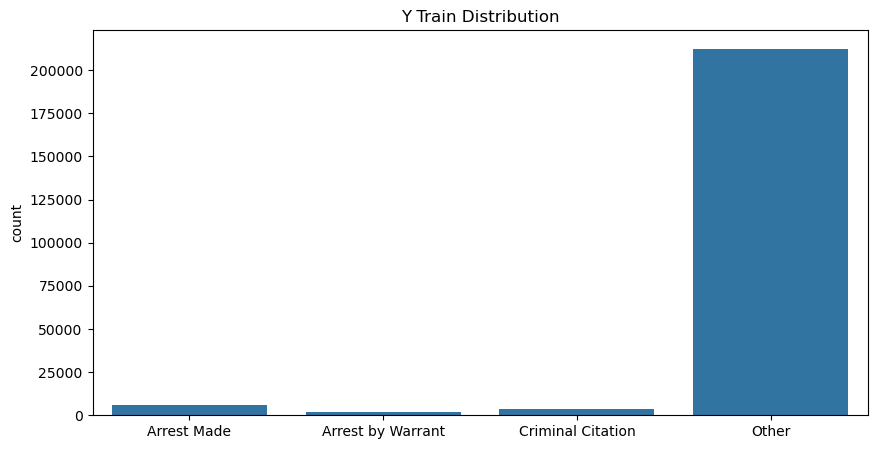

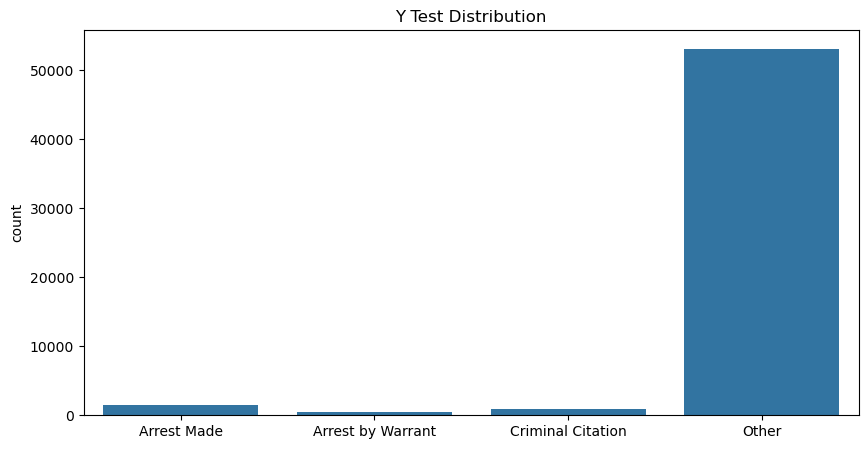

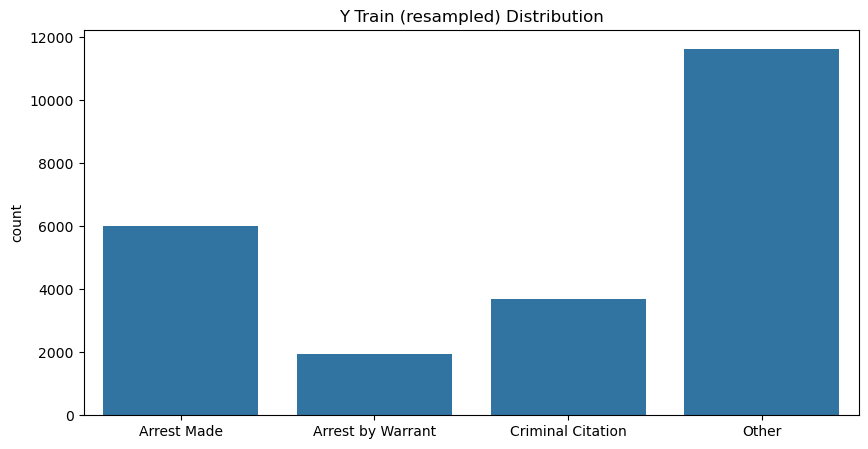

In [297]:
# Count the occurrences of each class in y_train and y_test
train_counts = collections.Counter(y_train)
test_counts = collections.Counter(y_test)

print("y_train distribution:", train_counts)
print("y_test distribution:", test_counts)

train_resampled_counts = collections.Counter(y_train_resampled)

print("y_train_resampled distribution:", train_counts)

# Bar plot for y_train
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_train)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(class_labels)
plt.title('Y Train Distribution')
plt.show()

# Bar plot for y_test
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_test)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(class_labels)
plt.title('Y Test Distribution')
plt.show()

# Bar plot for y_train_resampled
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_train_resampled)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(class_labels)
plt.title('Y Train (resampled) Distribution')
plt.show()

## Evaluate Different Baseline Models

### Most Frequent Class Model

In [301]:
# Step 1: Find the most frequent class in the training set
most_frequent_class = np.bincount(y_train).argmax()

In [303]:
# Step 2: Predict the most frequent class for all samples in the test set
y_pred_baseline = [most_frequent_class] * len(y_test)

In [305]:
# Step 3: Evaluate the baseline model
print("Baseline Model (Most Frequent Class) Classification Report:")
print(classification_report(y_test, y_pred_baseline, zero_division=0, target_names=label_names))

Baseline Model (Most Frequent Class) Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.00      0.00      0.00      1502
Arrest by Warrant       0.00      0.00      0.00       484
Criminal Citation       0.00      0.00      0.00       922
            Other       0.95      1.00      0.97     53122

         accuracy                           0.95     56030
        macro avg       0.24      0.25      0.24     56030
     weighted avg       0.90      0.95      0.92     56030



### Logistic Regression

In [308]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=1000, random_state=42)

In [309]:
y_pred_lr = lr_model.predict(X_test)
print("DONE")

DONE


In [310]:
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr, zero_division=0, target_names=label_names))

Logistic Regression Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.31      0.71      0.43      1502
Arrest by Warrant       0.71      0.61      0.66       484
Criminal Citation       0.20      0.64      0.30       922
            Other       0.99      0.91      0.95     53122

         accuracy                           0.90     56030
        macro avg       0.55      0.72      0.58     56030
     weighted avg       0.95      0.90      0.92     56030



#### Hyperparameter Tuning

In [312]:
grid_search_scoring_method = 'f1_macro'

In [317]:
# Define parameter grid
param_grid_lr = {
    'C': [0.1, 1, 10]
}

grid_lr = GridSearchCV(estimator=LogisticRegression(max_iter=1000, random_state=42), param_grid=param_grid_lr, 
                              cv=5, n_jobs=2, verbose=1, scoring=grid_search_scoring_method)

grid_lr.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=42),
             n_jobs=2, param_grid={'C': [0.1, 1, 10]}, scoring='f1_macro',
             verbose=1)

In [318]:
# Best parameters and score
print(f"Best Parameters: {grid_lr.best_params_}")
print(f"Best Score ({grid_search_scoring_method}): {grid_lr.best_score_:.4f}")

Best Parameters: {'C': 1}
Best Score (f1_macro): 0.6435


In [319]:
# Use the best estimator to make predictions
best_lr = grid_lr.best_estimator_

# save
joblib.dump(best_lr, f"models/{year}/best_logistic_regression.pkl") 

['models/2013/best_logistic_regression.pkl']

In [320]:
# load
best_lr = joblib.load(f"models/{year}/best_logistic_regression.pkl")

In [321]:
y_pred_best_lr = best_lr.predict(X_test)

# Evaluate the best model
print("Best Logistic Regression Classification Report for Police Calls:")
print(classification_report(y_test, y_pred_best_lr, zero_division=0, target_names=label_names))

Best Logistic Regression Classification Report for Police Calls:
                   precision    recall  f1-score   support

      Arrest Made       0.72      0.45      0.56      1502
Arrest by Warrant       0.79      0.61      0.69       484
Criminal Citation       0.64      0.27      0.38       922
            Other       0.97      0.99      0.98     53122

         accuracy                           0.96     56030
        macro avg       0.78      0.58      0.65     56030
     weighted avg       0.96      0.96      0.96     56030



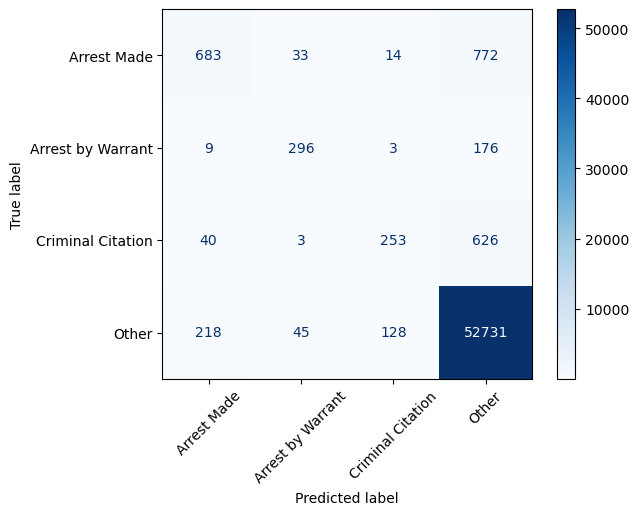

In [322]:
ConfusionMatrixDisplay.from_estimator(best_lr, X_test, y_test, display_labels=label_names, xticks_rotation=45, cmap=plt.cm.Blues)

#### Feature Importance

In [324]:
from sklearn.inspection import permutation_importance

# Calculate permutation feature importance on sample data to speed things up

# Sample 10% of X_test and y_test
sample_size = int(0.1 * len(X_test))
X_test_sample = X_test.sample(sample_size, random_state=42)

# Get the positional indices from the sample, and use them to index the numpy array y_test
pos_indices = X_test.index.get_indexer(X_test_sample.index)
y_test_sample = y_test[pos_indices]

permutation_importance_result = permutation_importance(best_lr, X_test_sample, y_test_sample, n_repeats=3, random_state=42)

In [325]:
# Create a DataFrame to store the feature importance results
importance_df = pd.DataFrame({
    'feature': X_test_sample.columns,
    'importance_mean': permutation_importance_result.importances_mean
})

# Define a mapping of one-hot encoded columns to their original categorical feature
# This is a dictionary where keys are the original feature names, and values are lists of one-hot encoded columns
one_hot_mapping = {
    'CALLTYPE_CODE': [col for col in X_test_sample.columns if col.startswith("CALLTYPE_CODE_")],
    'neighborhood': [col for col in X_test_sample.columns if col.startswith("neighborhood_")]
}

# Initialize a list to store aggregated and non-one-hot encoded features
final_importance = []

# 1. Aggregate the importance for one-hot encoded features
for original_feature, encoded_columns in one_hot_mapping.items():
    # Sum the importance of the one-hot encoded columns for this feature
    aggregated_importance = importance_df.loc[importance_df['feature'].isin(encoded_columns), 'importance_mean'].sum()
    final_importance.append({
        'feature': original_feature,
        'importance_mean': aggregated_importance
    })

# 2. Add the importance of the non-one-hot encoded features
# Find columns that are not part of the one-hot encoded mappings
all_one_hot_encoded_columns = [col for sublist in one_hot_mapping.values() for col in sublist]
non_one_hot_encoded_features = importance_df.loc[~importance_df['feature'].isin(all_one_hot_encoded_columns)]

# Append non-one-hot encoded features' importance to the final list
for _, row in non_one_hot_encoded_features.iterrows():
    final_importance.append({
        'feature': row['feature'],
        'importance_mean': row['importance_mean']
    })

# Convert final importance list to a DataFrame
final_importance_df = pd.DataFrame(final_importance)

# Sort by importance for easier interpretation
final_importance_df = final_importance_df.sort_values(by='importance_mean', ascending=False)

In [326]:
# Use display to see the dataframe nicely formatted
from IPython.display import display
display(final_importance_df)

,feature,importance_mean
0,CALLTYPE_CODE,0.032899
1,neighborhood,0.002261
2,PRIORITY,0.001785
5,DISTANCE_FROM_CENTER,0.001725
4,LONGITUDE,0.001249
8,LONGITUDE^2,0.000297
6,LATITUDE^2,0.000238
7,LATITUDE LONGITUDE,0.000119
9,AFTER_COVID_Yes,0.000000
3,LATITUDE,-0.000178


In [327]:
# Set maximum number of rows to display
pd.set_option('display.max_rows', 200)

In [338]:
feature_names = X_train.columns

feature_display_names = []

call_types = []
for feature_name in feature_names:
    if feature_name.startswith("CALLTYPE_CODE_"):
        code = feature_name[14:]
        call_type = call_type_code_mapping.get(code, '')
        call_types.append(call_type)
        if call_type != '':
            feature_display_names.append("Call Type: " + call_type)
        else:
            feature_display_names.append(feature_name)
    else:
        call_types.append("")
        feature_display_names.append(feature_name)

# Create a DataFrame of the results
perm_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': permutation_importance_result.importances_mean,
    'Call Type': call_types
})

# Sort by importance and display the top features
top_perm_features = perm_importance_df.sort_values(by='Importance', ascending=False).head(100)
print(top_perm_features)

                                    Feature  Importance  \
200                        CALLTYPE_CODE_6M    0.005414   
64                      CALLTYPE_CODE_11377    0.005354   
184                      CALLTYPE_CODE_601T    0.002439   
199                        CALLTYPE_CODE_6F    0.002320   
0                                  PRIORITY    0.001785   
3                      DISTANCE_FROM_CENTER    0.001725   
2                                 LONGITUDE    0.001249   
67                      CALLTYPE_CODE_11550    0.001071   
107                     CALLTYPE_CODE_23152    0.001071   
196                      CALLTYPE_CODE_647F    0.000952   
165                       CALLTYPE_CODE_484    0.000892   
65                     CALLTYPE_CODE_11377G    0.000833   
8                       CALLTYPE_CODE_1033A    0.000833   
132                       CALLTYPE_CODE_308    0.000714   
81                     CALLTYPE_CODE_12020G    0.000654   
86                        CALLTYPE_CODE_148    0.000654 

In [340]:
for index, coefficients in enumerate(best_lr.coef_):
    
    # Create a DataFrame of feature names and their corresponding coefficients
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Call Type': call_types
    })
    
    # Create a column that uses 'Call Type' if available, otherwise uses 'Feature'
    coef_df['Display Name'] = np.where(coef_df['Call Type'], "Call Type: " + coef_df['Call Type'], coef_df['Feature'])
    
    # Sort by the absolute value of the coefficients
    coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
    top_features = coef_df.sort_values(by='Abs_Coefficient', ascending=False).head(50)
    
    # Display the top most important features
    print(f"\nlabel = {label_names[index]}")
    print(top_features[['Display Name', 'Coefficient']])


label = Arrest Made
                                  Display Name  Coefficient
64          Call Type: POSSESSION OF NARCOTICS     3.235784
184                   Call Type: TRUANT (TABS)     3.064229
107                 Call Type: MISDEMEANOR DUI     3.055964
61   Call Type: POSSESSION OF CONTROLLED SUBST     3.005031
62   Call Type: POSSESSION OF CONTROLLED SUBST     2.779862
65   Call Type: POSSESSION OF NARCOTICS, GANG      2.761971
82      Call Type: CARRYING A CONCEALED WEAPON     2.757513
198    Call Type: PETTY THEFT PRIOR CONVICTION     2.581989
81    Call Type: ILLEGAL WEAPONS, GANG RELATED     2.301035
175       Call Type: MENTALLY DISTURBED PERSON     2.186233
108                      Call Type: FELONY DUI     2.137608
196                 Call Type: DRUNK IN PUBLIC     2.097715
87   Call Type: RESISTING ARREST, GANG RELATED     2.097352
60          Call Type: NARCOTICS, GANG RELATED     2.016342
86                 Call Type: RESISTING ARREST     1.972446
67      Call Type: 

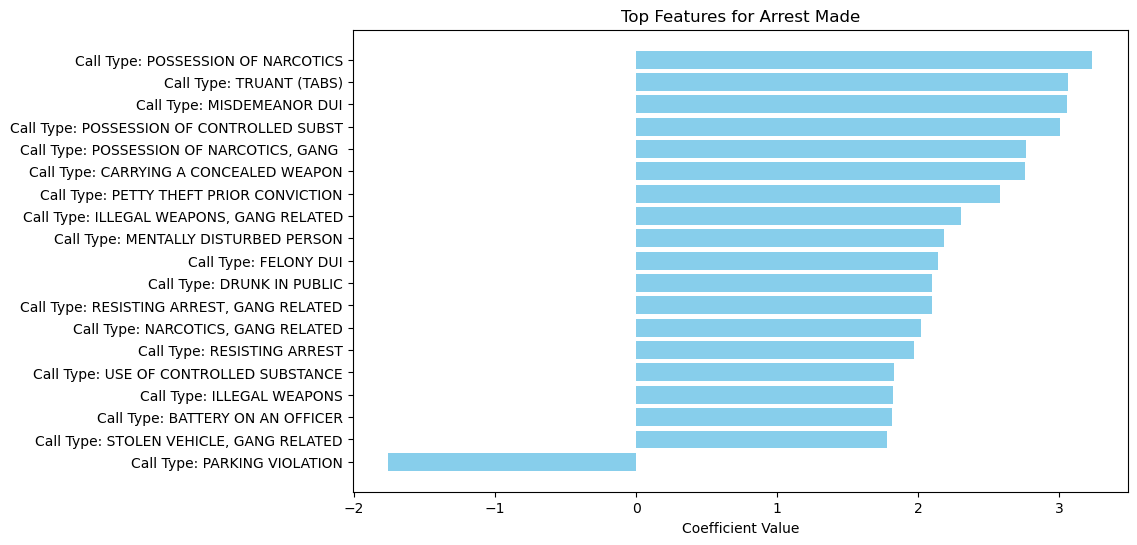

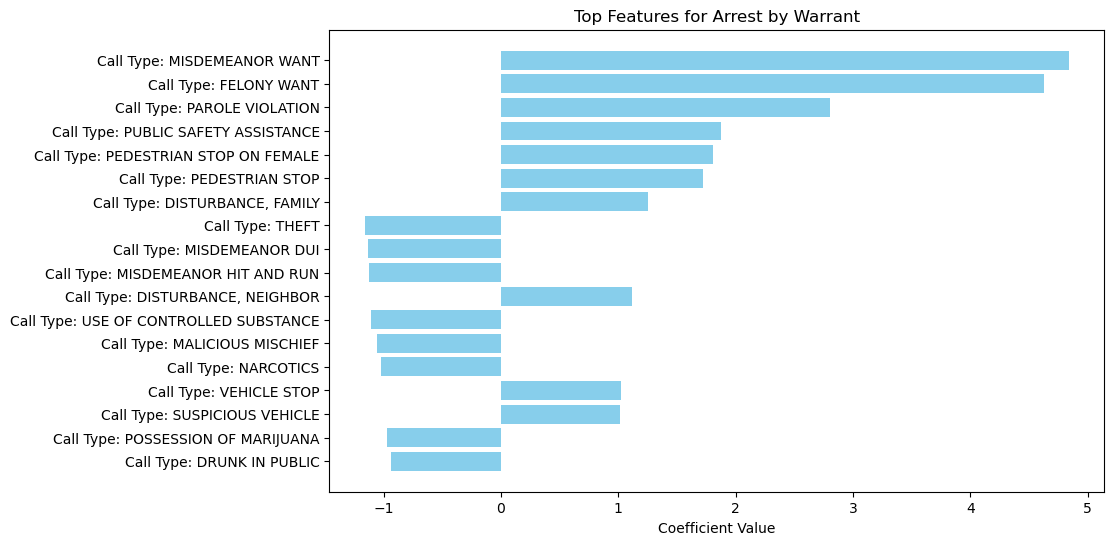

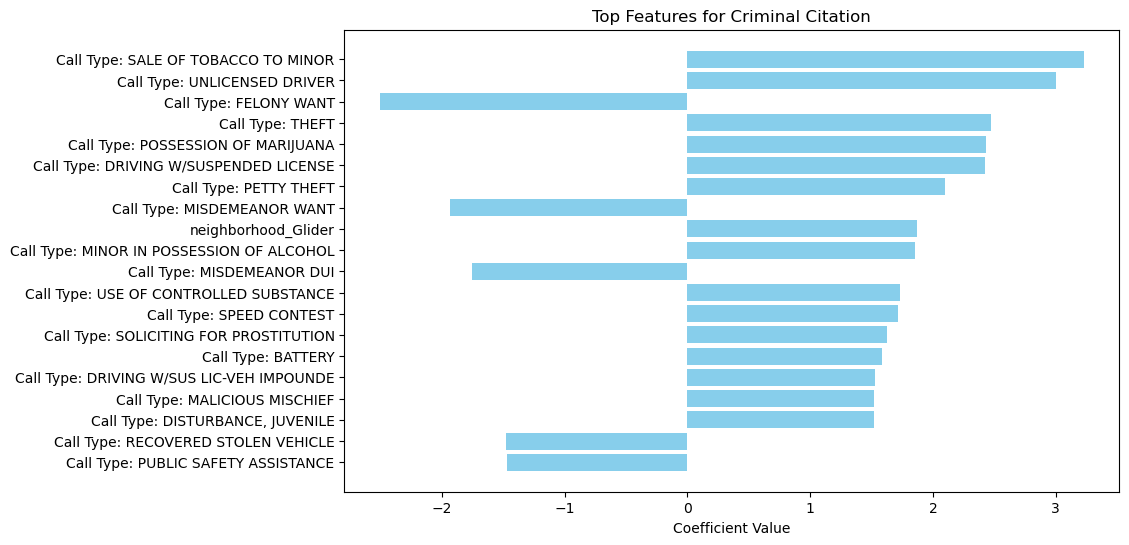

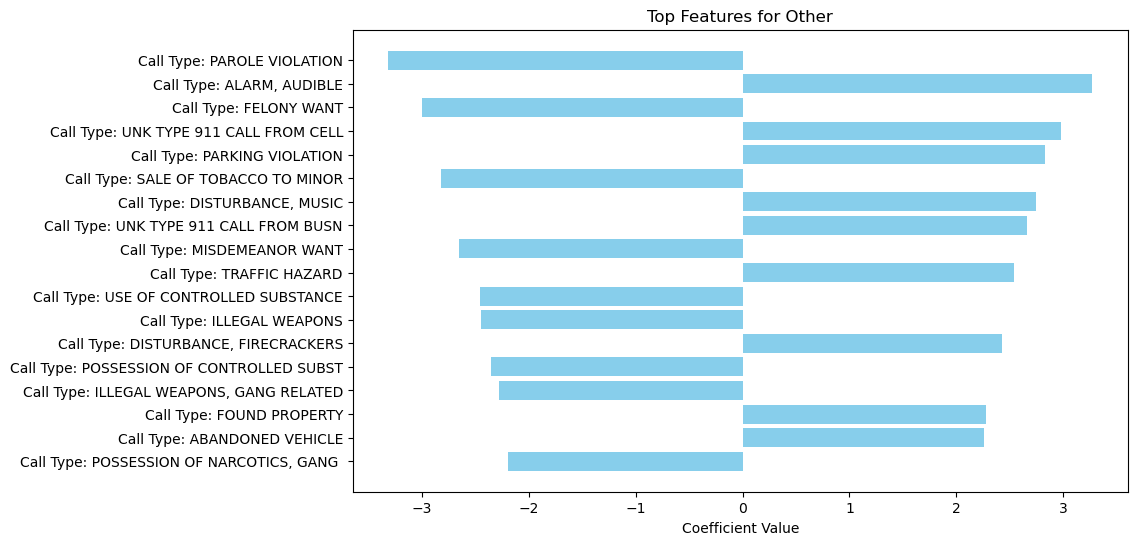

In [342]:
import matplotlib.pyplot as plt

for index, coefficients in enumerate(best_lr.coef_):
    
    # Create a DataFrame of feature names and their corresponding coefficients
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Call Type': call_types
    })

    # Create a column that uses 'Call Type' if available, otherwise uses 'Feature'
    coef_df['Display Name'] = np.where(coef_df['Call Type'], "Call Type: " + coef_df['Call Type'], coef_df['Feature'])
    
    # Sort by the absolute value of the coefficients
    coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
    top_features = coef_df.sort_values(by='Abs_Coefficient', ascending=False).head(20)
    
    # Plot the top coefficients as a bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(top_features['Display Name'], top_features['Coefficient'], color='skyblue')
    plt.xlabel('Coefficient Value')
    plt.title(f'Top Features for {label_names[index]}')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest coefficient at the top
    plt.show()


### Random Forest

In [345]:
rf_model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs = -1)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)

In [346]:
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, zero_division=0, target_names=label_names))

Random Forest Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.68      0.47      0.56      1502
Arrest by Warrant       0.72      0.55      0.63       484
Criminal Citation       0.54      0.35      0.43       922
            Other       0.97      0.99      0.98     53122

         accuracy                           0.96     56030
        macro avg       0.73      0.59      0.65     56030
     weighted avg       0.96      0.96      0.96     56030



#### Hyperparameter Tuning and Cross Validation

In [348]:
# Define parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 60],
}

# Initialize Grid Search
grid_rf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid_rf, n_jobs=-1,
                              cv=5, verbose=1, scoring=grid_search_scoring_method)

# Fit Grid Search
grid_rf.fit(X_train, y_train)

# Best parameters and score
print(f"Best Parameters: {grid_rf.best_params_}")
print(f"Best Score ({grid_search_scoring_method}): {grid_rf.best_score_:.2f}")

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Parameters: {'n_estimators': 50}
Best Score (f1_macro): 0.65


In [349]:
best_rf = grid_rf.best_estimator_

In [350]:
# save
joblib.dump(best_rf, f"models/{year}/best_random_forest.pkl") 

['models/2013/best_random_forest.pkl']

In [351]:
best_rf = joblib.load(f"models/{year}/best_random_forest.pkl")

In [352]:
# Use the best estimator to make predictions
y_pred_best_rf = best_rf.predict(X_test)

# Evaluate the best model
print("Best Random Forest Classification Report:")
print(classification_report(y_test, y_pred_best_rf, zero_division=0, target_names=label_names))

Best Random Forest Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.68      0.47      0.55      1502
Arrest by Warrant       0.73      0.56      0.63       484
Criminal Citation       0.54      0.35      0.42       922
            Other       0.97      0.99      0.98     53122

         accuracy                           0.96     56030
        macro avg       0.73      0.59      0.65     56030
     weighted avg       0.96      0.96      0.96     56030



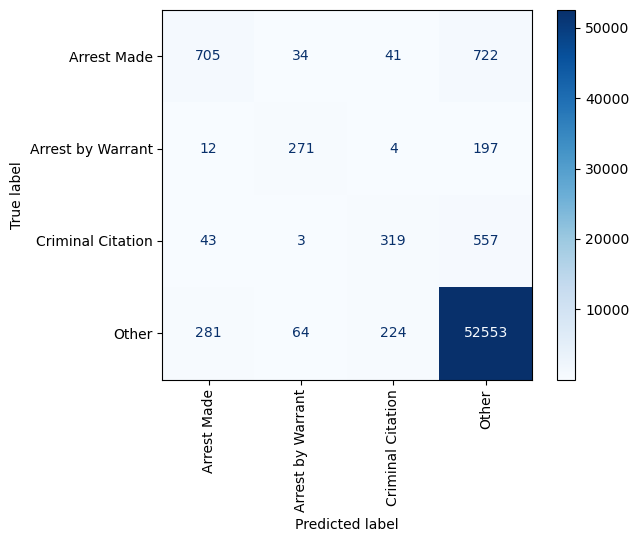

In [353]:
ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test, display_labels=label_names, xticks_rotation=90, cmap=plt.cm.Blues)

plt.show()

In [354]:
#### Optuna

def rf_objective(trial):
    # Suggest values for the hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 100)
    max_depth = trial.suggest_int('max_depth', 5, 100)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])

    # Initialize RandomForest with suggested hyperparameters
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )
    
    # Use cross-validation to evaluate the model
    score = cross_val_score(clf, X_train_resampled, y_train_resampled, cv=5, scoring='f1_macro').mean()
    return score

# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(rf_objective, n_trials=20)

# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

[I 2024-10-08 16:13:41,208] A new study created in memory with name: no-name-b4f5014f-301b-47cf-9705-9c3c717c5f5d
[I 2024-10-08 16:13:42,649] Trial 0 finished with value: 0.6912755129411463 and parameters: {'n_estimators': 96, 'max_depth': 47, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.6912755129411463.
[I 2024-10-08 16:13:44,368] Trial 1 finished with value: 0.7196910215829095 and parameters: {'n_estimators': 69, 'max_depth': 30, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.7196910215829095.
[I 2024-10-08 16:13:46,456] Trial 2 finished with value: 0.7228298555896584 and parameters: {'n_estimators': 94, 'max_depth': 46, 'min_samples_split': 14, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.7228298555896584.
[I 2024-10-08 16:13:48,673] Trial 3 finished with value: 0.7407933024329949 and parameters: {'n_estimators': 81, 'max_depth': 62, 'mi

Best hyperparameters: {'n_estimators': 78, 'max_depth': 81, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'sqrt'}


In [357]:
best_params = study.best_params
best_params

{'n_estimators': 78,
 'max_depth': 81,
 'min_samples_split': 6,
 'min_samples_leaf': 2,
 'max_features': 'sqrt'}

In [358]:
# Train the RandomForest using the best hyperparameters
best_rf_2 = RandomForestClassifier(**best_params, n_jobs=-1)
best_rf_2.fit(X_train, y_train)

RandomForestClassifier(max_depth=81, min_samples_leaf=2, min_samples_split=6,
                       n_estimators=78, n_jobs=-1)

In [359]:
# Use the best estimator to make predictions
y_pred_best_rf_2 = best_rf_2.predict(X_test)

# Evaluate the best model
print("Best Random Forest Classification Report:")
print(classification_report(y_test, y_pred_best_rf_2, zero_division=0, target_names=label_names))

Best Random Forest Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.76      0.48      0.59      1502
Arrest by Warrant       0.79      0.61      0.69       484
Criminal Citation       0.67      0.26      0.38       922
            Other       0.97      0.99      0.98     53122

         accuracy                           0.96     56030
        macro avg       0.80      0.59      0.66     56030
     weighted avg       0.96      0.96      0.96     56030



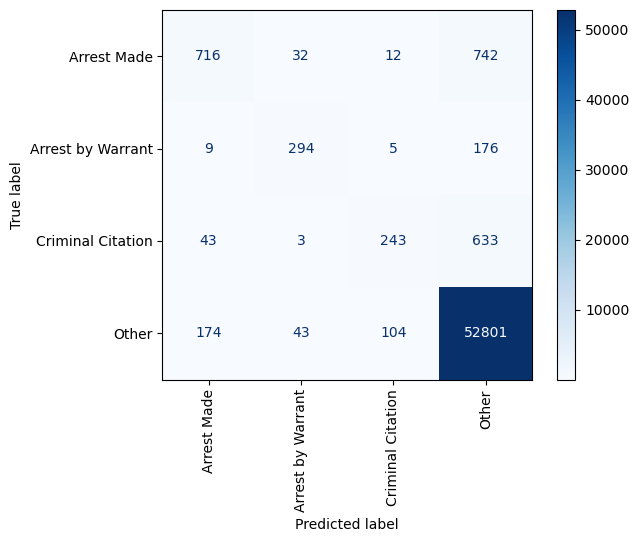

In [360]:
ConfusionMatrixDisplay.from_estimator(best_rf_2, X_test, y_test, display_labels=label_names, xticks_rotation=90, cmap=plt.cm.Blues)
plt.show()

#### Feature Importance

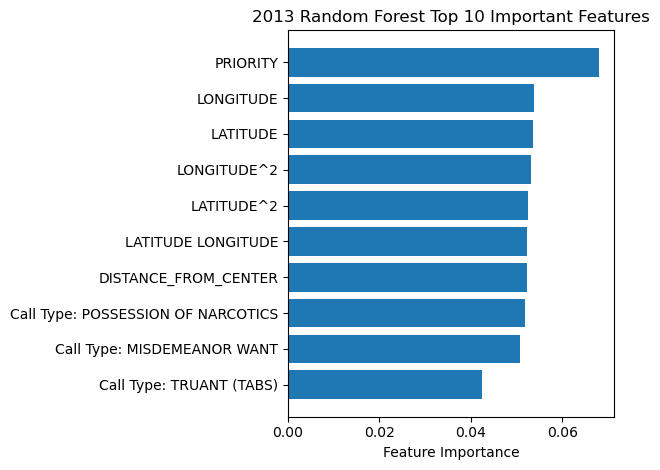

In [362]:
import numpy as np
import matplotlib.pyplot as plt

# Get feature importances and sort them in descending order
importances = best_rf.feature_importances_
indices = np.argsort(importances)[-10:]  # Select top 10 features

# Create a bar chart for the top 10 features
plt.barh(np.array(feature_display_names)[indices], importances[indices])
plt.xlabel('Feature Importance')
plt.title(f'{year} Random Forest Top 10 Important Features')
plt.tight_layout()  # Adjusts the padding automatically
plt.savefig(f'images/{year}_random_forest_feature_importance.png')
plt.show()

### Multilayer Perceptron Model

In [376]:
# Set up early stopping and model checkpoint callbacks so we choose the best model

# Define the callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',  # monitor validation loss
    patience=3,          # stop training if val_loss doesn't improve for N epochs
    restore_best_weights=True  # restore model to the epoch with the best val_loss
)

# Save the best model
model_checkpoint = ModelCheckpoint(
    'best_model.mcp.keras',    # path to save the best model
    monitor='val_loss', # monitor validation loss
    save_best_only=True # only save the model with the best val_loss
)

In [378]:
# Build the MLP model
mlp_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(512, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(len(np.unique(y_train)), activation='softmax')
])

mlp_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [380]:
# Train the model
history = mlp_model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, 
                        callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
2802/2802 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9501 - loss: 0.2083 - val_accuracy: 0.9657 - val_loss: 0.1310
Epoch 2/20
2802/2802 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9632 - loss: 0.1394 - val_accuracy: 0.9662 - val_loss: 0.1277
Epoch 3/20
2802/2802 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9643 - loss: 0.1320 - val_accuracy: 0.9659 - val_loss: 0.1264
Epoch 4/20
2802/2802 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9647 - loss: 0.1272 - val_accuracy: 0.9661 - val_loss: 0.1268
Epoch 5/20
2802/2802 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9661 - loss: 0.1235 - val_accuracy: 0.9658 - val_loss: 0.1289
Epoch 6/20
2802/2802 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9671 - loss: 0.1171 - val_accuracy: 0.9659 - val_loss: 0.1283


In [381]:
# save
joblib.dump(mlp_model, f"models/{year}/mlp_model.pkl") 

['models/2013/mlp_model.pkl']

In [382]:
mlp_model = joblib.load(f"models/{year}/mlp_model.pkl")

In [383]:
# Evaluate on test data
test_loss, test_acc = mlp_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc:.4f}')

1751/1751 ━━━━━━━━━━━━━━━━━━━━ 1s 463us/step - accuracy: 0.9651 - loss: 0.1297
Test Accuracy: 0.9645


In [384]:
# Make predictions
y_pred_nn = mlp_model.predict(X_test)
y_pred_nn_classes = np.argmax(y_pred_nn, axis=1)

# Classification report
print("Multilayer Perceptron Classification Report:")
print(classification_report(y_test, y_pred_nn_classes, zero_division=0, target_names=label_names))

1751/1751 ━━━━━━━━━━━━━━━━━━━━ 1s 463us/step
Multilayer Perceptron Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.77      0.48      0.59      1502
Arrest by Warrant       0.76      0.62      0.68       484
Criminal Citation       0.63      0.25      0.35       922
            Other       0.97      0.99      0.98     53122

         accuracy                           0.96     56030
        macro avg       0.78      0.58      0.65     56030
     weighted avg       0.96      0.96      0.96     56030



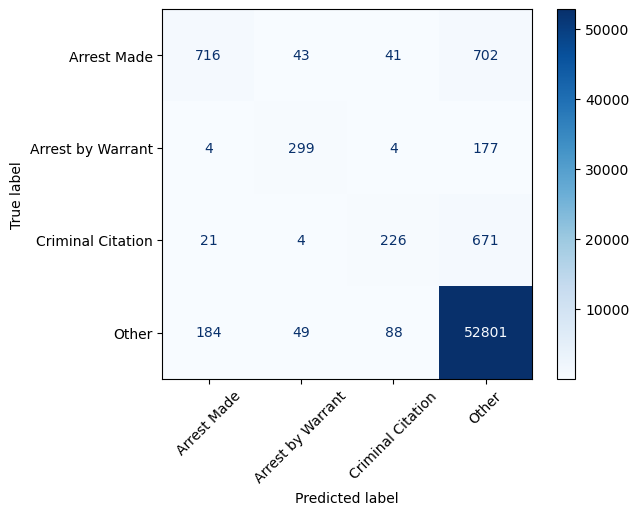

In [385]:
cm = confusion_matrix(y_test, y_pred_nn_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.show()

### XGBoost

In [388]:
def objective(trial):
    params = {
        'n_estimators': 300,
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
    }
    
    xgb_clf = XGBClassifier(**params, eval_metric='logloss')
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    try:
        scores = cross_val_score(xgb_clf, X_train_resampled, y_train_resampled, scoring='f1_macro', cv=cv, n_jobs=1)
        return np.mean(scores)
    except Exception as e:
        print(f"An error occurred: {e}")
        return float('-inf')

# Create a study object and specify the direction is 'maximize' for f1_macro score
study = optuna.create_study(direction='maximize')

# Number of trials
n_trials = 30

# Optimize the study
start_time = time.time()
study.optimize(objective, n_trials=n_trials, n_jobs=1, catch=(Exception,))
end_time = time.time()

actual_runtime = end_time - start_time
print(f"Actual runtime: {actual_runtime:.2f} seconds ({actual_runtime/60:.2f} minutes)")

# Print the best parameters and score
print("Best parameters found: ", study.best_params)
print("Best F1 macro score: ", study.best_value)

[I 2024-10-08 16:18:33,175] A new study created in memory with name: no-name-8a3b7a0b-fac8-4317-be6f-041cc6c764b9
[I 2024-10-08 16:18:52,687] Trial 0 finished with value: 0.7458208548036437 and parameters: {'learning_rate': 0.10786290649722549, 'max_depth': 3, 'subsample': 0.6436219831970315, 'colsample_bytree': 0.7900615900005887, 'gamma': 1.2639963594063516e-08, 'reg_alpha': 2.4223954295615995e-08, 'reg_lambda': 0.000177840341194594}. Best is trial 0 with value: 0.7458208548036437.
[I 2024-10-08 16:19:29,564] Trial 1 finished with value: 0.7398039397390095 and parameters: {'learning_rate': 0.08920209069576014, 'max_depth': 12, 'subsample': 0.8991932744151289, 'colsample_bytree': 0.769537384904511, 'gamma': 2.0045301412782834e-07, 'reg_alpha': 0.009656323370789456, 'reg_lambda': 0.0037740192739408934}. Best is trial 0 with value: 0.7458208548036437.
[I 2024-10-08 16:20:08,120] Trial 2 finished with value: 0.7089158635904214 and parameters: {'learning_rate': 0.0025593646375545657, 'max

Actual runtime: 710.54 seconds (11.84 minutes)
Best parameters found:  {'learning_rate': 0.16570925257639163, 'max_depth': 4, 'subsample': 0.9463951423128668, 'colsample_bytree': 0.8157773747770329, 'gamma': 1.2922523747999946e-06, 'reg_alpha': 4.560457892690628e-06, 'reg_lambda': 6.431077717595032e-07}
Best F1 macro score:  0.7521557265113794


In [389]:
# train the final model with the best parameters:
best_params = study.best_params
xgb_1_model = XGBClassifier(**best_params, eval_metric='logloss')
xgb_1_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8157773747770329, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=1.2922523747999946e-06, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.16570925257639163, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [390]:
y_pred_best_xgb = xgb_1_model.predict(X_test)

xgb_1_accuracy = accuracy_score(y_test, y_pred_best_xgb)
xgb_1_recall = recall_score(y_test, y_pred_best_xgb, average='macro')
xgb_1_prec = precision_score(y_test, y_pred_best_xgb, average='macro')
xgb_1_f1 = f1_score(y_test, y_pred_best_xgb, average='macro')

# Evaluate the best model
print("Best XGBoost Classification Report:")
print(classification_report(y_test, y_pred_best_xgb, zero_division=0, target_names=label_names))

Best XGBoost Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.79      0.44      0.57      1502
Arrest by Warrant       0.79      0.60      0.68       484
Criminal Citation       0.66      0.27      0.38       922
            Other       0.97      0.99      0.98     53122

         accuracy                           0.96     56030
        macro avg       0.80      0.58      0.65     56030
     weighted avg       0.96      0.96      0.96     56030



In [391]:
best_xg = xgb_1_model
joblib.dump(best_xg, f"models/{year}/xgb_model.pkl") 

['models/2013/xgb_model.pkl']

In [392]:
best_xg = joblib.load(f"models/{year}/xgb_model.pkl")

## Ensemble

In [394]:
best_lr = joblib.load(f"models/{year}/best_logistic_regression.pkl")
best_rf = joblib.load(f"models/{year}/best_random_forest.pkl")
best_xg = joblib.load(f"models/{year}/xgb_model.pkl")

In [395]:
print(f'LR F1: {f1_score(y_test, best_lr.predict(X_test), average='macro')}')
print(f'RF F1: {f1_score(y_test, best_rf.predict(X_test), average='macro')}')
print(f'XGB F1: {f1_score(y_test, best_xg.predict(X_test), average='macro')}')

LR F1: 0.6524276700849595
RF F1: 0.6477680356493216
XGB F1: 0.6531962042662629


In [396]:
best_lr

LogisticRegression(C=1, max_iter=1000, random_state=42)

In [397]:
best_rf

RandomForestClassifier(n_estimators=50)

In [398]:
best_xg

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8157773747770329, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=1.2922523747999946e-06, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.16570925257639163, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [399]:
estimators = [
    ('lr', best_lr),
    ('rf', best_rf),
    ('xg', best_xg)
]

base_estimators_fitted = [best_lr, best_rf, best_xg]

In [400]:
X_train_float = X_train.astype('float64')

In [401]:
stacking_clf_2 = StackingClassifier(estimators=estimators, final_estimator=XGBClassifier(), n_jobs=2)
stacking_clf_2.fit(X_train_float, y_train)

StackingClassifier(estimators=[('lr',
                                LogisticRegression(C=1, max_iter=1000,
                                                   random_state=42)),
                               ('rf', RandomForestClassifier(n_estimators=50)),
                               ('xg',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.8157773747770329,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              ev...
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=None, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=None, ...),
                   n_jobs=2)

In [402]:
joblib.dump(stacking_clf_2, f"models/{year}/stacking_2.pkl") 

['models/2013/stacking_2.pkl']

In [403]:
stacking_clf_2 = joblib.load(f"models/{year}/stacking_2.pkl")

In [404]:
y_pred_stacking_2 = stacking_clf_2.predict(X_test)
stack_2_accuracy = accuracy_score(y_test, y_pred_stacking_2)
stack_2_recall = recall_score(y_test, y_pred_stacking_2, average='macro')
stack_2_prec = precision_score(y_test, y_pred_stacking_2, average='macro')
stack_2_f1 = f1_score(y_test, y_pred_stacking_2, average='macro')
print(f"Stacking Classifier F1 Score: {stack_2_f1}")

Stacking Classifier F1 Score: 0.6767432406610047


In [405]:
print("Ensemble Classification Report:")
print(classification_report(y_test, y_pred_stacking_2, zero_division=0, target_names=label_names))

Ensemble Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.73      0.49      0.59      1502
Arrest by Warrant       0.77      0.60      0.68       484
Criminal Citation       0.62      0.37      0.46       922
            Other       0.97      0.99      0.98     53122

         accuracy                           0.96     56030
        macro avg       0.77      0.61      0.68     56030
     weighted avg       0.96      0.96      0.96     56030



## Results

In [407]:
from sklearn.metrics import f1_score

baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
lr_accuracy = accuracy_score(y_test, y_pred_best_lr)
rf_accuracy = accuracy_score(y_test, y_pred_best_rf)
mlp_accuracy = accuracy_score(y_test, y_pred_nn_classes)

baseline_recall = recall_score(y_test, y_pred_baseline, average='macro')
lr_recall = recall_score(y_test, y_pred_best_lr, average='macro')
rf_recall = recall_score(y_test, y_pred_best_rf, average='macro')
mlp_recall = recall_score(y_test, y_pred_nn_classes, average='macro')

baseline_prec = precision_score(y_test, y_pred_baseline, average='macro', zero_division=0)
lr_prec = precision_score(y_test, y_pred_best_lr, average='macro', zero_division=0)
rf_prec = precision_score(y_test, y_pred_best_rf, average='macro', zero_division=0)
mlp_prec = precision_score(y_test, y_pred_nn_classes, average='macro', zero_division=0)

baseline_f1 = f1_score(y_test, y_pred_baseline, average='macro')
lr_f1 = f1_score(y_test, y_pred_best_lr, average='macro')
rf_f1 = f1_score(y_test, y_pred_best_rf, average='macro')
mlp_f1 = f1_score(y_test, y_pred_nn_classes, average='macro')

results = pd.DataFrame({
    'Model': ['Baseline', 'Logistic Regression', 'Random Forest', 'MLP', 'XGB', 'Ensemble'],
    'Accuracy': [baseline_accuracy, lr_accuracy, rf_accuracy, mlp_accuracy, xgb_1_accuracy, stack_2_accuracy],
    'Recall': [baseline_recall, lr_recall, rf_recall, mlp_recall, xgb_1_recall, stack_2_recall],
    'Precision': [baseline_prec, lr_prec, rf_prec, mlp_prec, xgb_1_prec, stack_2_prec],
    'F1-score': [baseline_f1, lr_f1, rf_f1, mlp_f1, xgb_1_f1, stack_2_f1]
})
results.set_index('Model')

,Accuracy,Recall,Precision,F1-score
Model,,,,
Baseline,0.948099,0.250000,0.237025,0.243340
Logistic Regression,0.963109,0.583335,0.777697,0.652428
Random Forest,0.961057,0.591142,0.730232,0.647768
MLP,0.964519,0.583386,0.783006,0.651447
XGB,0.964501,0.576331,0.801717,0.653196
Ensemble,0.964858,0.613161,0.773260,0.676743


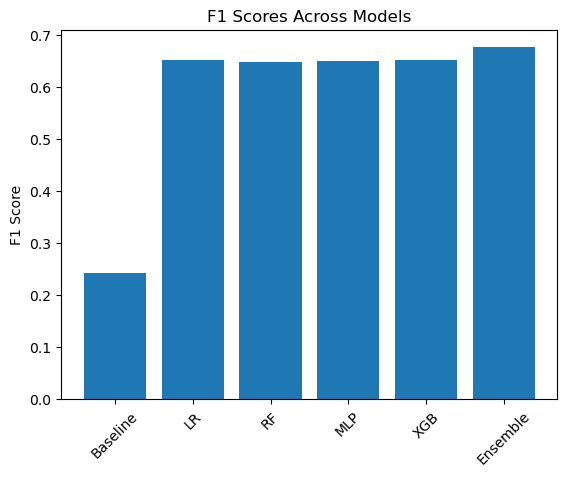

In [408]:
model_names = ['Baseline', 'LR', 'RF', 'MLP', 'XGB', 'Ensemble']
f1_scores = [baseline_f1, lr_f1, rf_f1, mlp_f1, xgb_1_f1, stack_2_f1]
plt.bar(model_names, f1_scores)
plt.xticks(rotation=45)
plt.ylabel('F1 Score')
plt.title('F1 Scores Across Models')
plt.show()

## Comparison with the All-Year Models

In [410]:
all_yr_lr = joblib.load("models/all_yr_best_logistic_regression.pkl")
all_yr_rf = joblib.load("models/all_yr_best_random_forest.pkl")
all_yr_xg = joblib.load("models/all_yr_xgb_model.pkl")
all_yr_stack = joblib.load("models/all_yr_stacking_2.pkl")

In [411]:
all_yr_lr_f1 = f1_score(y_test, all_yr_lr.predict(X_test), average='macro')
all_yr_rf_f1 = f1_score(y_test, all_yr_rf.predict(X_test), average='macro')
all_yr_xg_f1 = f1_score(y_test, all_yr_xg.predict(X_test), average='macro')
all_yr_stack_f1 = f1_score(y_test, all_yr_stack.predict(X_test), average='macro')

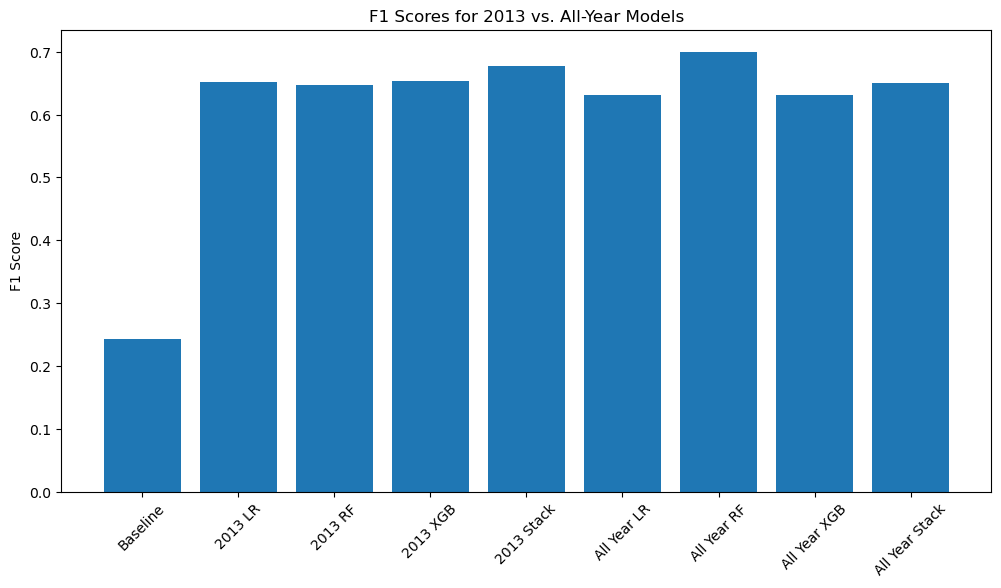

In [412]:
plt.figure(figsize=(12, 6))  # Adjust the width (12) and height (6) as needed

model_names = ['Baseline', f'{year} LR', f'{year} RF', f'{year} XGB', f'{year} Stack', 'All Year LR', 'All Year RF', 'All Year XGB', 'All Year Stack']
f1_scores = [baseline_f1, lr_f1, rf_f1, xgb_1_f1, stack_2_f1, all_yr_lr_f1, all_yr_rf_f1, all_yr_xg_f1, all_yr_stack_f1]
plt.bar(model_names, f1_scores)
plt.xticks(rotation=45)
plt.ylabel('F1 Score')
plt.title(f'F1 Scores for {year} vs. All-Year Models')
plt.show()

## 2013 vs. Non-2013 Models

In [414]:
other_years = [y for y in range(2013, 2025) if str(y) != year]
other_years

[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]

In [415]:
other_years_df = model_utils.load_data(other_years)
model_utils.transform_offense_date(other_years_df)
dispo_mapping = model_utils.calc_dispo_subset(other_years_df)
all_police_df.shape

(314546, 24)

In [416]:
other_years_clean = model_utils.clean_and_transform_data(other_years_df)
other_years_clean.shape

Police Calls Dataset: 3272311 rows before cleaning, 2920814 rows after cleaning.


(2920814, 15)

In [417]:
X_train_oy, X_test_oy, y_train_oy, y_test_oy, _, _, X_train_resampled_oy, y_train_resampled_oy, _ = \
    model_utils.split_data(other_years_clean, dispo_mapping, encoder)

classes = ['A' 'B' 'C' 'Other']
(2336651, 14)
(584163, 14)
['Arrest Made', 'Arrest by Warrant', 'Criminal Citation', 'Other']


/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Counter({3: 2244719, 0: 46591, 2: 25002, 1: 20339})
Counter({3: 91932, 0: 46591, 2: 25002, 1: 20339})


In [418]:
rf_model_oy = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs = -1)
rf_model_oy.fit(X_train_oy, y_train_oy)

RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)

In [419]:
y_pred_rf_oy = rf_model_oy.predict(X_test_oy)

print("Random Forest Other Years Classification Report for Non-2013 Data:")
print(classification_report(y_test_oy, y_pred_rf_oy, zero_division=0, target_names=label_names))

Random Forest Other Years Classification Report for Non-2013 Data:
                   precision    recall  f1-score   support

      Arrest Made       0.54      0.35      0.42     11648
Arrest by Warrant       0.67      0.52      0.58      5084
Criminal Citation       0.46      0.21      0.29      6251
            Other       0.98      0.99      0.98    561180

         accuracy                           0.97    584163
        macro avg       0.66      0.52      0.57    584163
     weighted avg       0.96      0.97      0.96    584163



In [420]:
y_pred_rf_oy_2013 = rf_model_oy.predict(X_test)

print("Random Forest Other Years Classification Report for 2013 Data:")
print(classification_report(y_test, y_pred_rf_oy_2013, zero_division=0, target_names=label_names))

Random Forest Other Years Classification Report for 2013 Data:
                   precision    recall  f1-score   support

      Arrest Made       0.69      0.47      0.56      1502
Arrest by Warrant       0.79      0.57      0.66       484
Criminal Citation       0.58      0.24      0.34       922
            Other       0.97      0.99      0.98     53122

         accuracy                           0.96     56030
        macro avg       0.76      0.57      0.64     56030
     weighted avg       0.96      0.96      0.96     56030



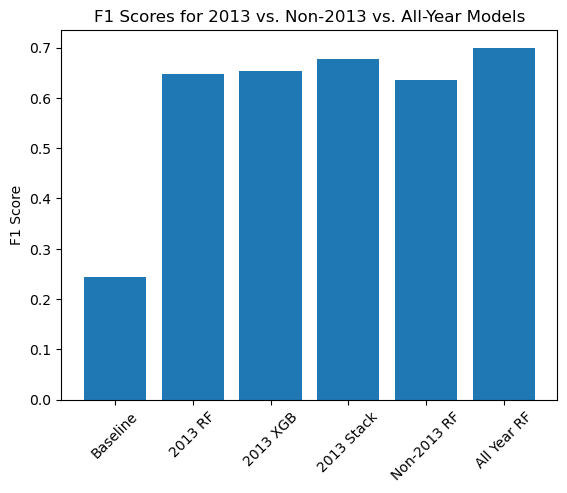

In [421]:
model_names = ['Baseline', f'{year} RF', f'{year} XGB', f'{year} Stack', f'Non-{year} RF', 'All Year RF']
f1_scores = [baseline_f1, rf_f1, xgb_1_f1, stack_2_f1, f1_score(y_test, y_pred_rf_oy_2013, average='macro'), all_yr_rf_f1]
plt.bar(model_names, f1_scores)
plt.xticks(rotation=45)
plt.ylabel('F1 Score')
plt.title(f'F1 Scores for {year} vs. Non-{year} vs. All-Year Models')
plt.show()